# Brain Training
This is the notebook where everything regarding NF Training will come together

# 1 Preparations

## 1.1 modules and where to put files
- double check all these parameters
- change sub and sess according to the current participant and session (!)
- double check the destination directory to be sure
- don't use the Template Notebook (if you do so...), but copy/paste a notebook into a subject/session specific directory!
- do not do this work just before a measurement. Have it prepared (and preferable tested!)

In [1]:
# import (most of the) modules that we need
import time
import re
import os
from multiprocessing import Process, Event
import numpy as np
import pylsl
from datetime import datetime
from nftools import guis
from nftools.mne import no_bad_samples, no_bad_channels, detect_channel_types
from nftools.threshold import find_mode, contiguous_regions, detect_bursts, determine_optimal_threshold
import mne
import dynarray
import pickle
from scipy import io as spio
import matplotlib.pyplot as plt

In [2]:
# use the qt event loop, disable warnings (they flood the screen)
%matplotlib qt  
# %gui qt

import warnings; warnings.filterwarnings('ignore') 
mne.set_config('MNE_LOGGING_LEVEL', 'WARNING')

## 1.2 Define sub, ion and run numbers
- this will also load all the available data - if they've already been recorded!

In [3]:
# change these according to which sub-sess we have:
sub = 21
ses = 1
run = 2
task = 'raw-nftraining'

In [4]:
# define where we put our stuff - prepare for BIDS Format Style
save_dir = '/home/johan/nf/rawdata/BrainTraining/bids'
this_save_dir = os.path.join(save_dir, 'sub-{:02d}'.format(sub), 'ses-{:02d}'.format(ses), 'eeg')

# we should also ... MAKE this savedir! If it exists, we don't do anything.
if not os.path.exists(this_save_dir):
    os.makedirs(this_save_dir)
    print("Directory " , this_save_dir ,  " Created ")
else:    
    print("Directory " , this_save_dir ,  " already exists")   
    
    
# expected files to be read/written:
fname_raw_eo_run = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'eo', run))
fname_raw_ec_run = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'ec', run))
fname_ica_ocular_rejection = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_ica-ocular-rejection_run-{:02d}.pkl'.format(sub, ses, run))
fname_csp_alpha_rejection = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_csp-alpha-rejection_run-{:02d}.pkl'.format(sub, ses, run))

fname_calibration_envelopes = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_calibration_envelopes_run-{:02d}.pkl'.format(sub, ses, run))
fname_calibration_parameters = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_calibration_parameters_run-{:02d}.pkl'.format(sub, ses, run))

fname_raw_nftraining_run = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'raw-nftraining', run))
fname_rtanalyzed_nftraining_eeg = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'rtanalyzed-nftraining-eeg', run))
fname_rtanalyzed_nftraining_emg = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, 'rtanalyzed-nftraining-emg', run))


# if files exist, load them
if os.path.exists(fname_raw_eo_run):
    print('found raw eyes open: \t\t' + os.path.basename(fname_raw_eo_run))
    raw_eo = mne.io.read_raw_fif(fname_raw_eo_run, preload=True)
if os.path.exists(fname_raw_ec_run):
    print('found raw eyes closed: \t\t' + os.path.basename(fname_raw_ec_run))
    raw_ec = mne.io.read_raw_fif(fname_raw_ec_run, preload=True)
if os.path.exists(fname_ica_ocular_rejection):
    print('found ica eyeblink rejection:\t' + os.path.basename(fname_ica_ocular_rejection))
    with open(fname_ica_ocular_rejection,'rb') as f:
        ica_rejection = pickle.load(f)
if os.path.exists(fname_csp_alpha_rejection):
    print('found csp alpha rejection: \t' + os.path.basename(fname_csp_alpha_rejection))
    with open(fname_csp_alpha_rejection, 'rb') as f:
        csp_rejection = pickle.load(f)

if os.path.exists(fname_calibration_envelopes):
    print('found calibration envelopes: \t' + os.path.basename(fname_calibration_envelopes))
    with open(fname_calibration_envelopes, 'rb') as f: 
        calibration_envelopes = pickle.load(f)
    locals().update(calibration_envelopes)
if os.path.exists(fname_calibration_parameters):
    print('found calibration parameters: \t' + os.path.basename(fname_calibration_parameters))
    with open(fname_calibration_parameters, 'rb') as f: 
        calibration_parameters = pickle.load(f)
    locals().update(calibration_parameters)
        
if os.path.exists(fname_raw_nftraining_run):
    print('found raw nftraining: \t\t' + os.path.basename(fname_raw_nftraining_run))
    raw_nftraining = mne.io.read_raw_fif(fname_raw_nftraining_run)
if os.path.exists(fname_rtanalyzed_nftraining_eeg):
    print('found rt-analyzed eeg: \t\t' + os.path.basename(fname_rtanalyzed_nftraining_eeg))
    rtanalyzed_nftraining_eeg = mne.io.read_raw_fif(fname_rtanalyzed_nftraining_eeg)
if os.path.exists(fname_rtanalyzed_nftraining_emg):
    print('found rt-analyzed emg: \t\t' + os.path.basename(fname_rtanalyzed_nftraining_emg))
    rtanalyzed_nftraining_emg = mne.io.read_raw_fif(fname_rtanalyzed_nftraining_emg)        

Directory  /home/johan/nf/rawdata/BrainTraining/bids/sub-21/ses-01/eeg  already exists
found raw eyes open: 		sub-21_ses-01_task-eo_run-02.fif
found raw eyes closed: 		sub-21_ses-01_task-ec_run-02.fif
found ica eyeblink rejection:	sub-21_ses-01_ica-ocular-rejection_run-02.pkl
found csp alpha rejection: 	sub-21_ses-01_csp-alpha-rejection_run-02.pkl
found calibration envelopes: 	sub-21_ses-01_calibration_envelopes_run-02.pkl
found calibration parameters: 	sub-21_ses-01_calibration_parameters_run-02.pkl
found raw nftraining: 		sub-21_ses-01_task-raw-nftraining_run-02.fif
found rt-analyzed eeg: 		sub-21_ses-01_task-rtanalyzed-nftraining-eeg_run-02.fif
found rt-analyzed emg: 		sub-21_ses-01_task-rtanalyzed-nftraining-emg_run-02.fif


In [6]:
raw_nftraining = mne.io.read_raw_fif(fname_raw_nftraining_run, preload=True)

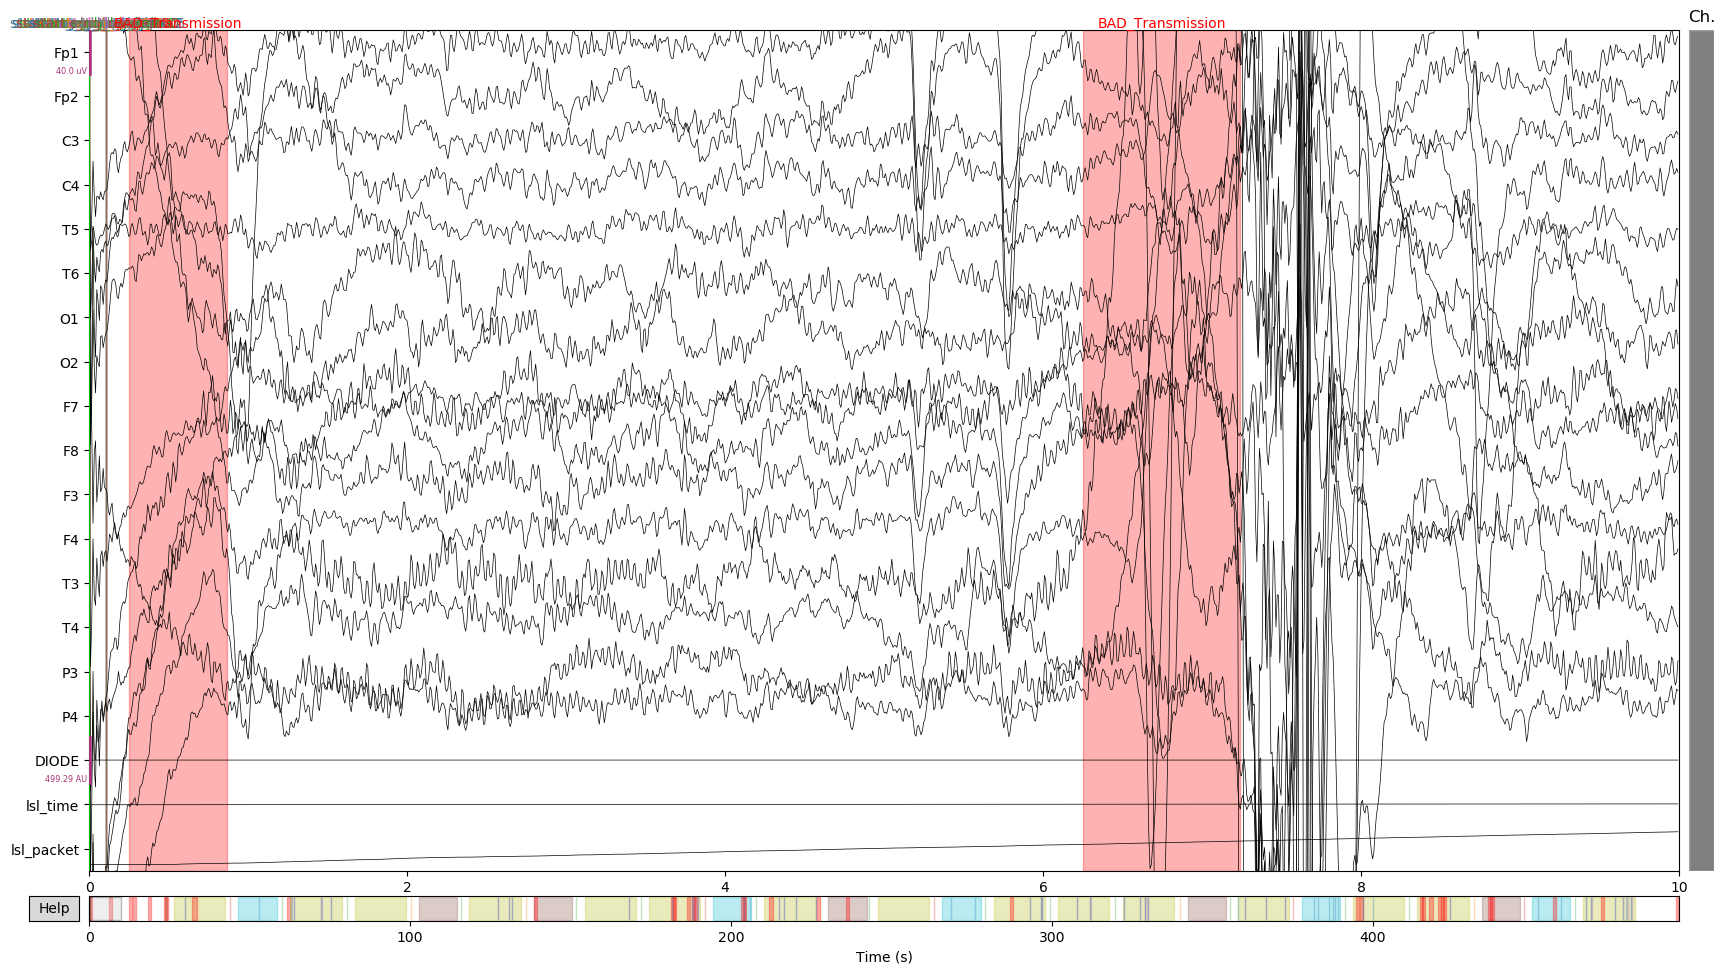

In [7]:
raw_nftraining.copy().filter(1, 35).plot()

In [6]:
playback_file = os.path.join(this_save_dir, 'sub-{:02d}_ses-{:02d}_task-{}_run-{:02d}.fif'.format(sub, ses, task, run))
print('playing back:')
print(playback_file)

playing back:
/home/johan/nf/rawdata/BrainTraining/bids/sub-01/ses-01/eeg/sub-01_ses-01_task-raw-nftraining_run-14.fif


In [7]:
raw = mne.io.read_raw_fif(playback_file, preload=True)

In [8]:
# we need to transpose data, and then we can for-loop over it like so (extensively verbose):
def send_it(data_file, stopit):

    import mne
    # data_file = '/home/johan/nf/nf-rtime/Projects_Templates/3_RTMRICWL/trial_data_for_mri_cwl_development.set'

    raw = mne.io.read_raw_fif(data_file, preload=True)
    
    for ch in ('lsl_time','lsl_packet'): # remove the lsl stuff I put on (later):
        if ch in raw.ch_names:
            raw.drop_channels(ch)
            print('dropped: {ch_name}'.format(ch_name=ch))
    
    raw_scaling = [item['cal'] for item in raw.info['chs']]
    sfreq=raw.info['sfreq']
    
    print(raw)
    # create info for our purposes:
    info = pylsl.StreamInfo('Playback_eeg_3', 'EEG', len(raw.ch_names), raw.info['sfreq'], 'float32', 'this_is_eeg_')

    chns = info.desc().append_child("channels")
    for label in raw.ch_names:
        ch = chns.append_child("channel")
        ch.append_child_value("label", label)
        ch.append_child_value("unit", "microvolts")
        ch.append_child_value("type", "EEG")

    outlet = pylsl.StreamOutlet(info)

    # time_to_send_new_data_point = time.time()
    # time_to_wait_between_sending_data_points = 1/sfreq

    # we loop the playback indefinitely - so I don't have to restart it always:
    all_data = raw.get_data().T  / 1E-6

    while True and not stopit.is_set():
        begin_time = time.time()
        current_time = 0.0

        inds_sent = np.zeros(raw.last_samp+1, dtype=bool)
        while current_time < raw.last_samp/raw.info['sfreq'] and not stopit.is_set():

            inds_current = raw.times < current_time
            bool_slice = inds_current & ~inds_sent
            if bool_slice.any():
                b=np.min(np.where(bool_slice)[0])
                e=np.max(np.where(bool_slice)[0])+1


                stamp = pylsl.local_clock()-0.125
                outlet.push_chunk(all_data[b:e,:].tolist(), stamp)
                inds_sent = inds_sent | inds_current

                no_data_time=0

            time.sleep(0.0005)
            current_time = time.time() - begin_time

        print('We are done sending this data - restarting...')

    print('now we are really done - removing the outlet, you have to finish up by joining the thread...')
    del(outlet)
        


In [9]:
pylsl.local_clock()

125450.313825848

In [10]:
stopit = Event()
p=Process(target=send_it, args=(playback_file, stopit))

In [11]:
p.start()

dropped: lsl_time
dropped: lsl_packet
<Raw  |  sub-01_ses-01_task-raw-nftraining_run-14.fif, n_channels x n_times : 16 x 92265 (738.1 sec), ~11.3 MB, data loaded>
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are done sending this data - restarting...
We are do

In [12]:
p.pid

518416

In [13]:
# prints out which streams are currently available
[ pylsl.stream_inlet(s).info().name() for s in pylsl.resolve_streams() ]

['Playback_eeg_3']

In [14]:
# stopping the process once we're done:

In [13]:
stopit.set()

In [14]:
p.join()